In [2]:
import sys
import os
import flopy as fp
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats

sys.path.append("../modules")
from Rouss1 import *

In [3]:
workspace = "workspace"
model_name = "test_trans"
exe_name="../exe/mf6.exe"

In [4]:
# create simulation
sim = fp.mf6.MFSimulation(sim_name=model_name, version='mf6', exe_name=exe_name, 
                             sim_ws=workspace)

# create tdis package
tdis_rc = [(1.0, 1, 1.0)]
nper=36
for i in range(nper-1):
    tdis_rc.append((30.0,10,1.0))

tdis = fp.mf6.ModflowTdis(sim, pname='tdis', time_units='DAYS', 
                             nper=nper, perioddata=tdis_rc)

# create gwf model
gwf = fp.mf6.ModflowGwf(sim, modelname=model_name,
                           model_nam_file='{}.nam'.format(model_name))
gwf.name_file.save_flows = True

# create iterative model solution and register the gwf model with it
ims = fp.mf6.ModflowIms(sim, pname='ims', print_option='SUMMARY', 
                           complexity='moderate', outer_hclose=0.0001, 
                           outer_maximum=500, under_relaxation='NONE', 
                           inner_maximum=100, inner_hclose=0.0001, 
                           rcloserecord=0.001, linear_acceleration='CG', 
                           scaling_method='NONE', reordering_method='NONE', 
                           relaxation_factor=0.97)
#sim.register_ims_package(ims, [gwf.name])

In [5]:
# dis
nlay = 1
nrow = 30
ncol = 30
dis = fp.mf6.ModflowGwfdis(gwf, pname='dis', nlay=nlay, nrow=nrow, ncol=ncol, 
                              delr=10, delc=10, top=30.0, 
                              botm=23,idomain=1, 
                              filename='{}.dis'.format(model_name))

# initial conditions
ic = fp.mf6.ModflowGwfic(gwf, pname='ic', strt=25,
                            filename='{}.ic'.format(model_name))

# node property flow
npf = fp.mf6.ModflowGwfnpf(gwf, pname='npf', save_flows=True, 
                              icelltype=1,k=1e-4*86400)

# output control
oc = fp.mf6.ModflowGwfoc(gwf, pname='oc', budget_filerecord='{}.cbb'.format(model_name),
                            head_filerecord='{}.hds'.format(model_name),
                            saverecord=[('HEAD', 'ALL'), ('BUDGET', 'ALL')],
                            printrecord=[('HEAD', 'FIRST'), ('HEAD', 'LAST'), 
                                         ('BUDGET', 'LAST')])

In [6]:
# storage package
sy = 0.2
ss = 0.00001
sto = fp.mf6.ModflowGwfsto(gwf, pname='sto', save_flows=True, iconvert=1, 
                              ss=ss, sy=sy, steady_state={0:True},
                              transient={1:True}) 

In [7]:
#variable recharge 
i=0
dic_rch={}
rch_lst=np.array([1000.0,1200.0,900,600,450,300,200,400,600,800,900,1000])
rch_lst = rch_lst/(1000*365) # m/j
for im in range(nper):
    if i >=12:
        i = 0
    dic_rch[im]=rch_lst[i]
    i+=1
rcha = fp.mf6.modflow.mfgwfrcha.ModflowGwfrcha(gwf, recharge=dic_rch)

In [8]:
#create fake variations of the constant head limit following a normal distribution

asc = np.sort(np.random.normal(25,0.5,size=6))
dsc = np.sort(np.random.normal(25,0.5,size=6))[::-1]
chd_ts = np.ones(12)
chd_ts[0:6] = asc
chd_ts[6:] = dsc

In [9]:
#constant head

chd_spd={} # dic with all the data at each period
chd_p=[] #data within a single period
i=0
for im in range(nper):
    if i >=12:
        i = 0
    for irow in range(nrow):
        chd_p.append(((0,irow,ncol-1),chd_ts[i]))
    chd_spd[im]=chd_p
    chd_p=[]
    i+=1      

chd = fp.mf6.ModflowGwfchd(gwf,pname="chd",stress_period_data=chd_spd)

In [10]:
# observation --> {filename:[("observation name","type of observation",(cellid)),
#                            ("observation name2","flux observation",(cellid2n),(cellid2m))]
#                  filename2:[(observation name3,"type of observation3,(cellid3)")]}

obs_recarray = {'head_obs.csv':[('h1', 'HEAD', (0, 1, 27))],
                'intercell_flow_obs1.csv':[('ICF1_1.0', 'FLOW-JA-FACE', (0, 4, 5), (0, 5, 5))],
                'heads.csv':[('h3-13-9', 'HEAD', (0, 12, 8))]}
obs_package = fp.mf6.ModflowUtlobs(gwf, pname='head_obs', filename='{}.obs'.format(model_name), 
                                      digits=10, print_input=True,
                                      continuous=obs_recarray)

In [11]:
sim.write_simulation()
sim.run_simulation()

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing ims package ims...
  writing model test_trans...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package npf...
    writing package oc...
    writing package sto...
    writing package rcha...
    writing package chd...
INFORMATION: maxbound in ('gwf6', 'chd', 'dimensions') changed to 30 based on size of stress_period_data
    writing package head_obs...
FloPy is using the following  executable to run the model: ../exe/mf6.exe
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                            VERSION 6.0.4 03/13/2019

   MODFLOW 6 compiled Mar 21 2019 15:37:31 with IFORT compiler (ver. 19.0.0)

This software has been approved for release by the U.S. Geological 
Survey (USGS). Although the software has been subjected to rigorous 
review, the USGS reserves the right to u

 Solving:  Stress period:    14    Time step:     8
 Solving:  Stress period:    14    Time step:     9
 Solving:  Stress period:    14    Time step:    10
 Solving:  Stress period:    15    Time step:     1
 Solving:  Stress period:    15    Time step:     2
 Solving:  Stress period:    15    Time step:     3
 Solving:  Stress period:    15    Time step:     4
 Solving:  Stress period:    15    Time step:     5
 Solving:  Stress period:    15    Time step:     6
 Solving:  Stress period:    15    Time step:     7
 Solving:  Stress period:    15    Time step:     8
 Solving:  Stress period:    15    Time step:     9
 Solving:  Stress period:    15    Time step:    10
 Solving:  Stress period:    16    Time step:     1
 Solving:  Stress period:    16    Time step:     2
 Solving:  Stress period:    16    Time step:     3
 Solving:  Stress period:    16    Time step:     4
 Solving:  Stress period:    16    Time step:     5
 Solving:  Stress period:    16    Time step:     6
 Solving:  S

 Solving:  Stress period:    31    Time step:     9
 Solving:  Stress period:    31    Time step:    10
 Solving:  Stress period:    32    Time step:     1
 Solving:  Stress period:    32    Time step:     2
 Solving:  Stress period:    32    Time step:     3
 Solving:  Stress period:    32    Time step:     4
 Solving:  Stress period:    32    Time step:     5
 Solving:  Stress period:    32    Time step:     6
 Solving:  Stress period:    32    Time step:     7
 Solving:  Stress period:    32    Time step:     8
 Solving:  Stress period:    32    Time step:     9
 Solving:  Stress period:    32    Time step:    10
 Solving:  Stress period:    33    Time step:     1
 Solving:  Stress period:    33    Time step:     2
 Solving:  Stress period:    33    Time step:     3
 Solving:  Stress period:    33    Time step:     4
 Solving:  Stress period:    33    Time step:     5
 Solving:  Stress period:    33    Time step:     6
 Solving:  Stress period:    33    Time step:     7
 Solving:  S

(True, [])

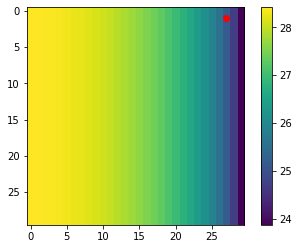

In [12]:
hds_path = os.path.join(workspace, model_name + '.hds')
hds = fp.utils.HeadFile(hds_path)
head2 = hds.get_data(kstpkper=(5,1))
plt.imshow(head2[0])
plt.colorbar()
plt.scatter(27,1,color="r")

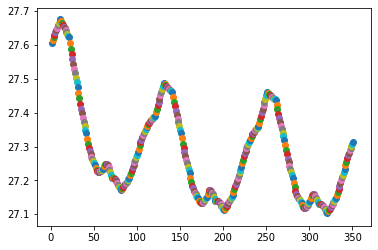

In [20]:
i=0
for it in hds.get_kstpkper():
    head2 = hds.get_data(kstpkper=it)
    i+=1
    plt.scatter(i,head2[0,1,15])

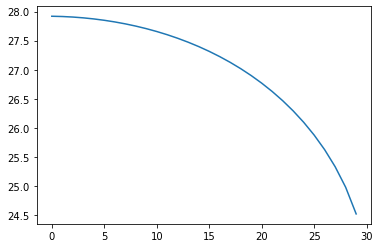

In [14]:
#head cross section
plt.plot(head2[0,5,:])

In [15]:
#budget
cbb_path = os.path.join(workspace, model_name + '.cbb')
cbb = fp.utils.CellBudgetFile(cbb_path,precision="double")


Text(0, 0.5, 'head [m]')

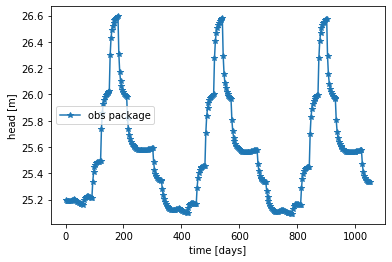

In [24]:
h = pd.read_csv("workspace/head_obs.csv")["H1"]
t = pd.read_csv("workspace/head_obs.csv")["time"]
plt.plot(t,h,"*-",label="obs package",)

plt.legend(["obs package"])
plt.xlabel("time [days]")
plt.ylabel("head [m]")

In [17]:
head = hds.get_alldata()

In [18]:
head.shape

(351, 1, 30, 30)

In [ ]:
def makePDF_animated(head,filename,vmin,vmax,title):
    from matplotlib.backends.backend_pdf import PdfPages
    with PdfPages('youpi.pdf') as pdfout:
        for i, chead in enumerate(head):
            printhead = np.squeeze(chead)
            plt.figure(figsize=(8,8))
            plt.imshow(printhead,
                      interpolation='nearest',
                      vmin=vmin,
                      vmax=vmax)
            plt.colorbar()
            plt.title(title)
            pdfout.savefig()
            plt.close()

In [ ]:
makePDF_animated(head,"youpi",24,28,"put title here pls")